# Meep FDTD

[Meep](https://meep.readthedocs.io/en/latest/) is a free and open source finite-difference time-domain (FDTD) software package for electromagnetic simulations spanning a broad range of applications.

You can install Meep and the mode solver MPB (which Meep uses to compute S-parameters and launch mode sources) using one of two methods:

1. Mamba (faster)

```
mamba install pymeep=*=mpi_mpich_* -y
```

2. Conda

```
conda install -c conda-forge pymeep=*=mpi_mpich_* -y
```

To update the installed package, you would do:

```
mamba update pymeep=*=mpi_mpich_* -y
```

The Mamba/Conda packages are available for Linux, macOS, or Windows [WSL](https://docs.microsoft.com/en-us/windows/wsl/). For more details on installing Meep, see the [user manual](https://meep.readthedocs.io/en/latest/Installation/#conda-packages).


The gdsfactory `gmeep` plugin computes the transmission spectrum for planar photonic components.

One advantage of using the `gmeep` plugin is that you only need to define your component geometry *once* using gdsfactory. The geometry is automatically imported into Meep. There is no need to define the geometry separately for Meep.

For extracting S-parameters, `gmeep` automatically swaps the source between ports to compute the full S-matrix. This process involves:

- adding monitors to each port of the device
- extending the ports into the PML absorbing boundary layers
- running the simulation and computing elements of the S-matrix in post-processing using the correct ratio of S-parameters. The port monitors are used to compute the discrete-time Fourier-transformed (DTFT) fields which are then decomposed into complex mode coefficients known as S-parameters. The S-parameters can be computed over a range of frequencies.

The resolution is in units of pixels/μm. As a general rule, you should run with at least `resolution=30` for 1/30 μm/pixel (33 nm/pixel)

Note that most of the examples use `resolution=20` in order to run fast.

Here are some examples of how to extract S-parameters in Meep in planar devices.

For Sparameters we follow the syntax `o1@0,o2@0` where `o1` is the input port `@0` mode 0 (usually fundamental TE mode) and `o2@0` refers to output port `o2` mode 0.


```bash

         top view
              ________________________________
             |                               |
             | xmargin_left                  | port_extension
             |<--------->       port_margin ||<-->
          o2_|___________          _________||_o3
             |           \        /          |
             |            \      /           |
             |             ======            |
             |            /      \           |
          o1_|___________/        \__________|_o4
             |   |                 <-------->|
             |   |ymargin_bot   xmargin_right|
             |   |                           |
             |___|___________________________|

        side view
              ________________________________
             |                     |         |
             |                     |         |
             |                   zmargin_top |
             |xmargin_left         |         |
             |<---> _____         _|___      |
             |     |     |       |     |     |
             |     |     |       |     |     |
             |     |_____|       |_____|     |
             |       |                       |
             |       |                       |
             |       |zmargin_bot            |
             |       |                       |
             |_______|_______________________|



```

## Serial Simulation (single core)

Running Meep using a single CPU core can be slow as the single core needs to update all the simulation grid points sequentially at each time step.

In [1]:
import autograd.numpy as npa
from autograd import tensor_jacobian_product
from meep.adjoint import (
    conic_filter,
    DesignRegion,
    get_conic_radius_from_eta_e,
    tanh_projection,
)
import meep.adjoint as mpa
from meep import MaterialGrid, Medium, Vector3, Volume
import meep as mp
from gdsfactory.simulation.add_simulation_markers import add_simulation_markers
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gdsfactory as gf
import gdsfactory.simulation.gmeep as gm
import gdsfactory.simulation as sim

gf.config.set_plot_options(show_subports=False, show_ports=False)

Using MPI version 4.0, 1 processes


/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2023-01-22 16:16:40.913 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.23.4


2023-01-22 16:16:41.789 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/klayout/tech/layers.lyp.


2023-01-22 16:16:42.246 | INFO     | gdsfactory.simulation.gmeep:<module>:34 - Meep '1.25.0-beta' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep']


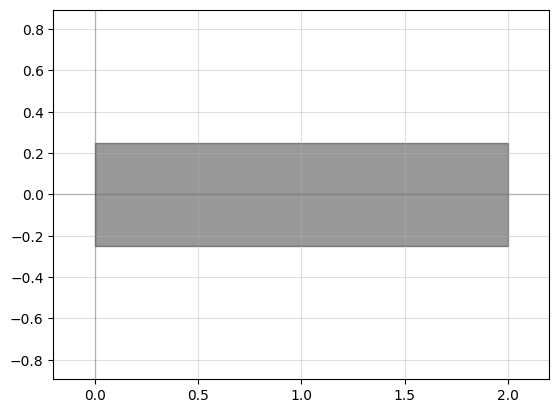

straight_length2: uid 910ca30e, ports ['o1', 'o2'], references [], 1 polygons

In [2]:
c = gf.components.straight(length=2)
c

`run=False` only plots the simulations for you to review that is set up **correctly**

[16:16:42] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=983693;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=836594;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py#102\102]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.8.2                                                     ]8;id=880738;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=762602;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py#120\120]8;;\

2023-01-22 16:16:43.238 | INFO     | gdsfactory.simulation.gtidy3d:<module>:54 - Tidy3d '1.8.2' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d']


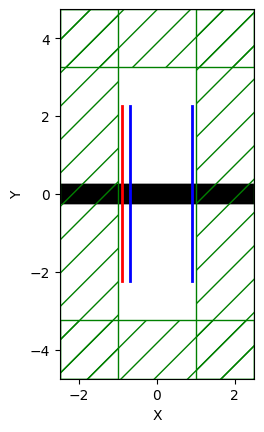

In [3]:
sp = gm.write_sparameters_meep(c, run=False, ymargin_top=3, ymargin_bot=3, is_3d=False)

In [4]:
help(gm.write_sparameters_meep)

Help on cython_function_or_method in module gdsfactory.simulation.gmeep.write_sparameters_meep:

write_sparameters_meep(component: 'ComponentSpec', port_source_names: 'Optional[List[str]]' = None, port_symmetries: 'Optional[PortSymmetries]' = None, resolution: 'int' = 30, wavelength_start: 'float' = 1.5, wavelength_stop: 'float' = 1.6, wavelength_points: 'int' = 50, dirpath: 'Optional[PathType]' = None, layer_stack: 'Optional[LayerStack]' = None, port_margin: 'float' = 2, port_monitor_offset: 'float' = -0.1, port_source_offset: 'float' = -0.1, filepath: 'Optional[Path]' = None, overwrite: 'bool' = False, animate: 'bool' = False, lazy_parallelism: 'bool' = False, run: 'bool' = True, dispersive: 'bool' = False, xmargin: 'float' = 0, ymargin: 'float' = 3, xmargin_left: 'float' = 0, xmargin_right: 'float' = 0, ymargin_top: 'float' = 0, ymargin_bot: 'float' = 0, decay_by: 'float' = 0.001, is_3d: 'bool' = False, z: 'float' = 0, plot_args: 'Dict' = None, **settings) -> 'Dict'
    Returns Spar

As you've noticed we added `ymargin_top` and `ymargin_bot` to ensure we have enough distance to the PML

You can also do this directly with another version of the function that adds `ymargin_top` and `ymargin_bot`

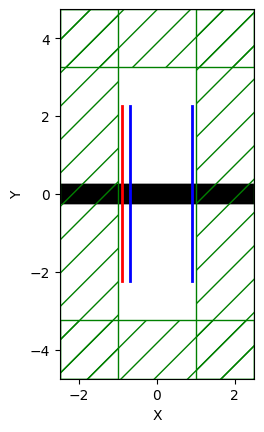

In [5]:
c = gf.components.straight(length=2)
sp = gm.write_sparameters_meep(c, run=False, is_3d=False)

Because components with `left-right` ports are very common `write_sparameters_meep` `y_margin = 3um `

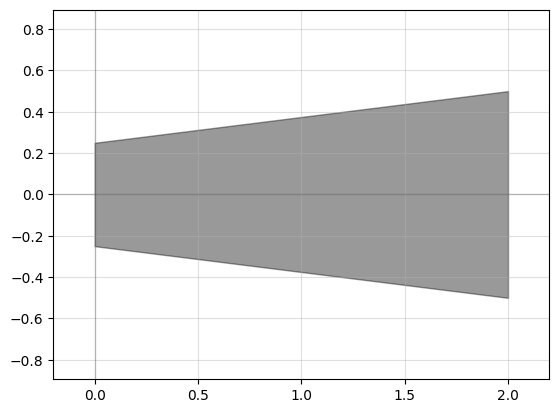

taper_length2p0_width21: uid 8e4e425f, ports ['o1', 'o2'], references [], 1 polygons

In [6]:
c = gf.components.taper(length=2.0, width1=0.5, width2=1)
c

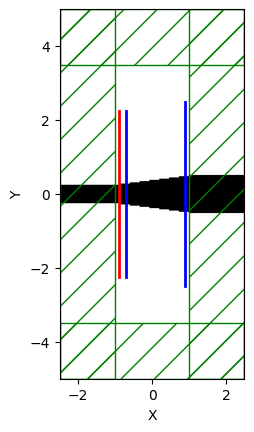

In [7]:
sp = gm.write_sparameters_meep(c, run=False)

## 2.5D Simulation

For faster simulations you can do an effective mode approximation, to compute the mode of the slab and run a 2D simulation to speed your [simulations](https://www.lumerical.com/learn/whitepapers/lumericals-2-5d-fdtd-propagation-method/)

In [8]:
ncore = sim.get_effective_indices(
    ncore=3.4777,
    ncladding=1.444,
    nsubstrate=1.444,
    thickness=0.22,
    wavelength=1.55,
    polarization="te",
)[0]

ncore

2.8494636999424405

In [9]:
sp = gm.write_sparameters_meep(
    c, resolution=20, is_3d=False, material_name_to_meep=dict(si=ncore)
)

2023-01-22 16:16:44.047 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:350 - Simulation loaded from PosixPath('/home/runner/.gdsfactory/sp/taper_length2p0_width21_a9be9ab2.npz')


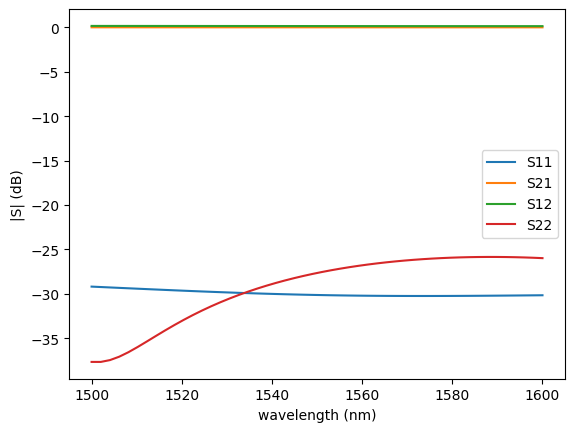

In [10]:
gf.simulation.plot.plot_sparameters(sp)

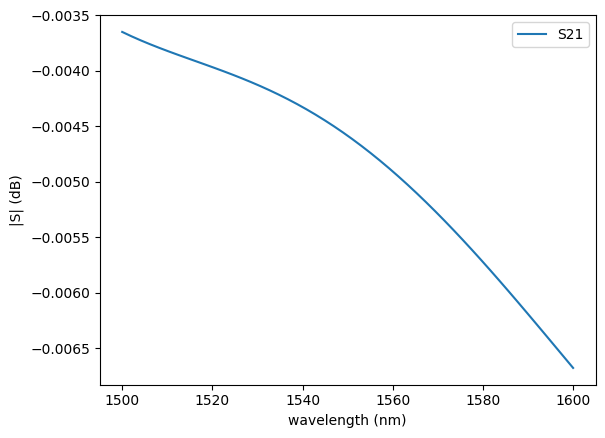

In [11]:
gf.simulation.plot.plot_sparameters(sp, keys=("o2@0,o1@0",))

For a small taper length, the matrix element S$_{21}$ (transmission in Port 2 given a source in Port 1) is around 0 dB which is equivalent to ~100% transmission.

## Port Symmetries

You can skip redundant simulations in reciprocal devices.
If the device looks the same going from in -> out as out -> in, we just need to run one simulation.

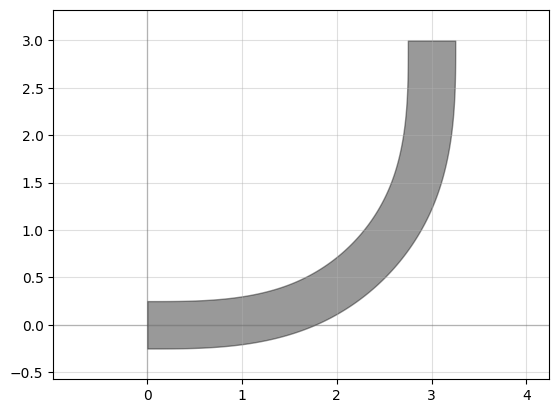

bend_euler_radius3: uid 0b06da0c, ports ['o1', 'o2'], references [], 1 polygons

In [12]:
c = gf.components.bend_euler(radius=3)
c

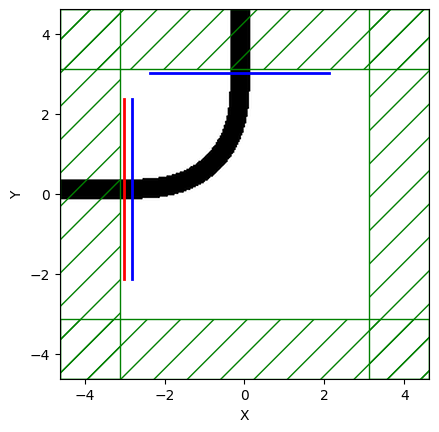

In [13]:
sp = gm.write_sparameters_meep_1x1_bend90(c, run=False)

In [14]:
sp = gm.write_sparameters_meep_1x1_bend90(c, run=True)

2023-01-22 16:16:46.122 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:350 - Simulation loaded from PosixPath('/home/runner/.gdsfactory/sp/bend_euler_radius3_f93a201a.npz')


In [15]:
list(sp.keys())

['o1@0,o1@0', 'o2@0,o1@0', 'o2@0,o2@0', 'o1@0,o2@0', 'wavelengths']

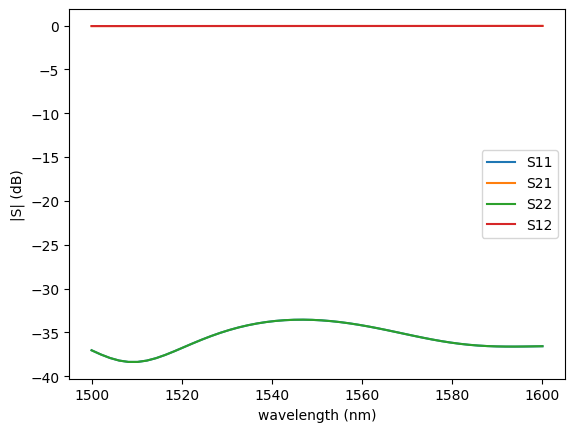

In [16]:
gf.simulation.plot.plot_sparameters(sp)

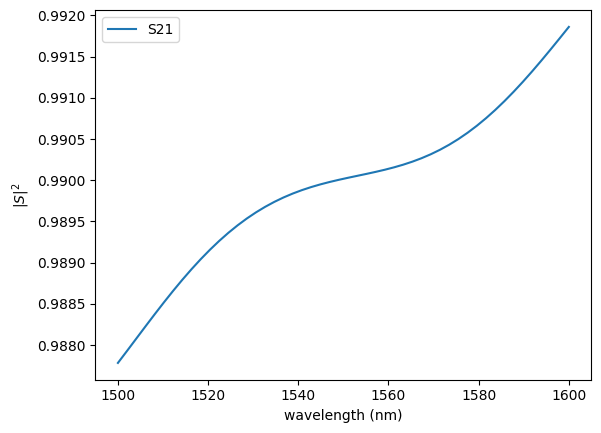

In [17]:
gf.simulation.plot.plot_sparameters(sp, keys=("o2@0,o1@0",), logscale=False)

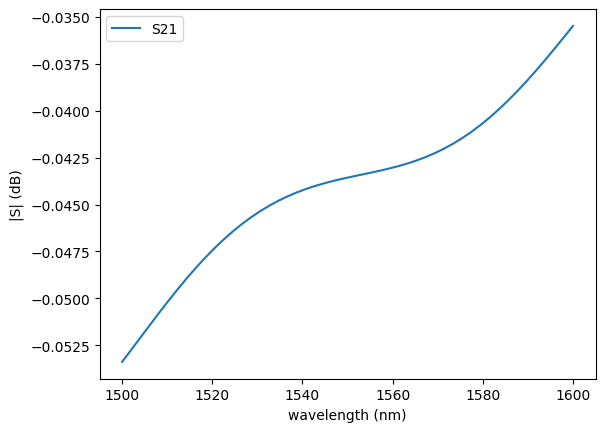

In [18]:
gf.simulation.plot.plot_sparameters(sp, keys=("o2@0,o1@0",))

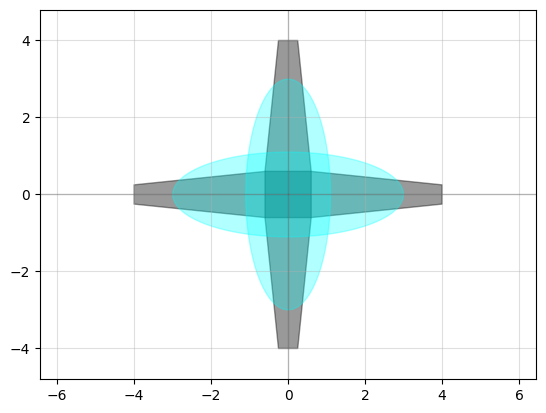

crossing: uid dcf7059c, ports ['o1', 'o3', 'o4', 'o2'], references [], 4 polygons

In [19]:
c = gf.components.crossing()
c

Here are the port symmetries for a crossing

```python
port_symmetries_crossing = {
    "o1": {
        "o1@0,o1@0": ["o2@0,o2@0", "o3@0,o3@0", "o4@0,o4@0"],
        "o2@0,o1@0": ["o1@0,o2@0", "o3@0,o4@0", "o4@0,o3@0"],
        "o3@0,o1@0": ["o1@0,o3@0", "o2@0,o4@0", "o4@0,o2@0"],
        "o4@0,o1@0": ["o1@0,o4@0", "o2@0,o3@0", "o3@0,o2@0"],
    }
}
```

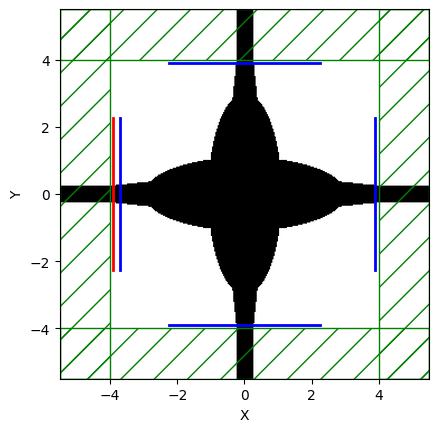

In [20]:
sp = gm.write_sparameters_meep(
    c,
    resolution=20,
    ymargin=0,
    port_symmetries=gm.port_symmetries.port_symmetries_crossing,
    run=False,
)

In [21]:
sp = gm.write_sparameters_meep(
    c,
    resolution=20,
    ymargin=0,
    port_symmetries=gm.port_symmetries.port_symmetries_crossing,
    run=True,
)

2023-01-22 16:16:47.680 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:350 - Simulation loaded from PosixPath('/home/runner/.gdsfactory/sp/crossing_f2a749f0.npz')


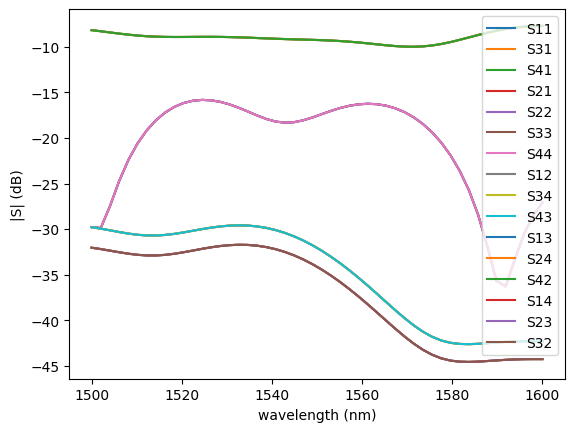

In [22]:
gm.plot.plot_sparameters(sp)

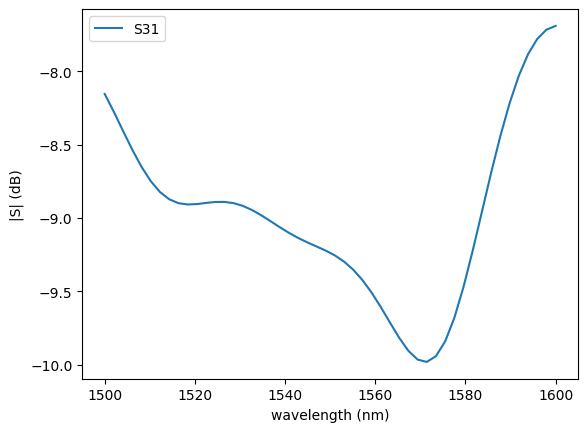

In [23]:
gm.plot.plot_sparameters(sp, keys=("o3@0,o1@0",))

As you can see this crossing looks beautiful but is quite **lossy** (9 dB @ 1550 nm)

## Parallel Simulation (multicore/MPI)

Meep supports [distributed-memory parallelization via MPI](https://meep.readthedocs.io/en/latest/Parallel_Meep/) which can be used to provide a significant speedup compared to serial calculations.

By default MPI just runs the same copy of the Python script everywhere, with the C++ under MEEP actually being parallelized.

`divide_parallel_processes` allows us to logically split this one calculation into (in this case "cores") subdivisions.
The only difference in the scripts is that a different integer n is returned depending on the subdivision it is running in.

So we use that n to select different sources, and each subdivision calculates its own Sparams independently.
Afterwards, we collect all the results in one of the subdivisions (if rank == 0)

As a demonstration, lets try to reproduce the results of the directional coupler results from the [Meep manual](https://meep.readthedocs.io/en/latest/Python_Tutorials/GDSII_Import/) which indicates that to obtain a 3 dB (50%/50%) splitter you need a separation distance of 130 nm over a coupler length of 8 μm.

In [24]:
help(gf.components.coupler)

Help on function coupler in module gdsfactory.components.coupler:

coupler(gap: 'float' = 0.236, length: 'float' = 20.0, coupler_symmetric: 'ComponentSpec' = <function coupler_symmetric at 0x7fa86fd6fd30>, coupler_straight: 'ComponentSpec' = <function coupler_straight at 0x7fa86fd6fb80>, dy: 'float' = 5.0, dx: 'float' = 10.0, cross_section: 'CrossSectionSpec' = 'strip', **kwargs) -> 'Component'
    Symmetric coupler.
    
    Args:
        gap: between straights in um.
        length: of coupling region in um.
        coupler_symmetric: spec for bend coupler.
        coupler_straight: spec for straight coupler.
        dy: port to port vertical spacing in um.
        dx: length of bend in x direction in um.
        cross_section: spec (CrossSection, string or dict).
        kwargs: cross_section settings.
    
    .. code::
    
               dx                                 dx
            |------|                           |------|
         o2 ________                           ___

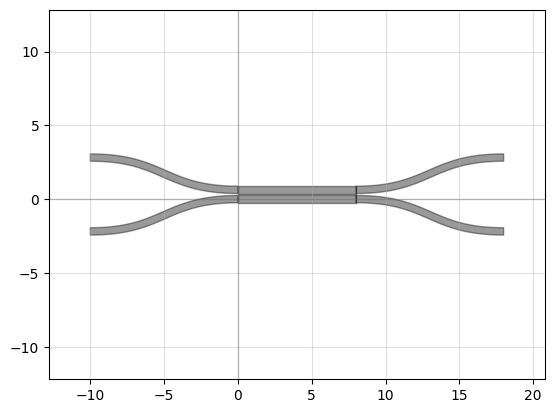

coupler_gap0p13_length8: uid fa096164, ports ['o1', 'o2', 'o3', 'o4'], references [], 6 polygons

In [25]:
c = gf.components.coupler(length=8, gap=0.13)
c

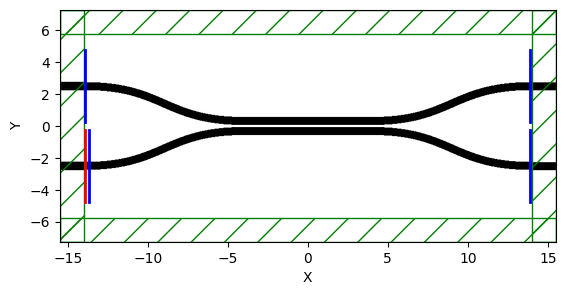

In [26]:
gm.write_sparameters_meep(component=c, run=False)

In [27]:
filepath = gm.write_sparameters_meep_mpi(
    component=c,
    cores=4,
    resolution=30,
)

2023-01-22 16:16:52.507 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/runner/.gdsfactory/sp/coupler_gap0p13_length8_48e9af33.npz') already exists


In [28]:
sp = np.load(filepath)

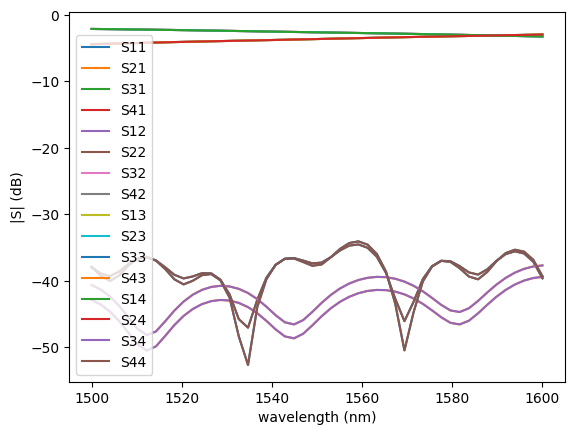

In [29]:
gf.simulation.plot.plot_sparameters(sp)

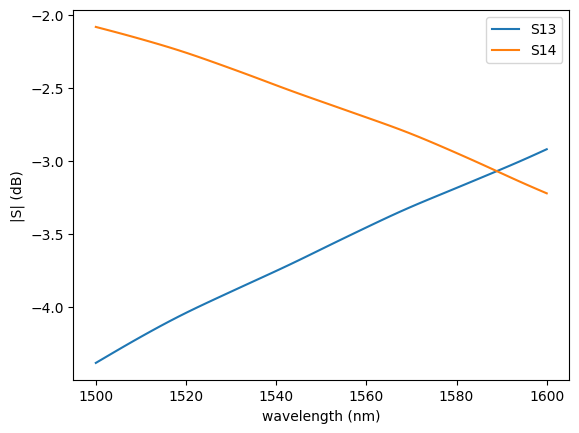

In [30]:
gf.simulation.plot.plot_sparameters(sp, keys=["o1@0,o3@0", "o1@0,o4@0"])

## Batch Simulations

You can also run a batch of multicore simulations.

Given a list of write_sparameters_meep keyword arguments `jobs` launches them in different cores using MPI where each simulation runs with "cores_per_run" cores.

If there are more simulations than cores each batch runs sequentially.

In [31]:
help(gm.write_sparameters_meep_batch)

Help on cython_function_or_method in module gdsfactory.simulation.gmeep.write_sparameters_meep_batch:

write_sparameters_meep_batch(jobs: 'List[Dict]', cores_per_run: 'int' = 2, total_cores: 'int' = 4, temp_dir: 'Path' = PosixPath('/home/runner/.gdsfactory/sp/temp'), delete_temp_files: 'bool' = True, dirpath: 'Optional[Path]' = None, layer_stack: 'Optional[LayerStack]' = None, **kwargs) -> 'List[Path]'
    Write Sparameters for a batch of jobs using MPI and returns results filepaths.
    
    Given a list of write_sparameters_meep keyword arguments `jobs` launches them in
    different cores using MPI where each simulation runs with `cores_per_run` cores.
    If there are more simulations than cores each batch runs sequentially.
    
    
    Args
        jobs: list of Dicts containing the simulation settings for each job.
            for write_sparameters_meep.
        cores_per_run: number of processors to assign to each component simulation.
        total_cores: total number of core

In [32]:
c = gf.components.straight(length=3.1)

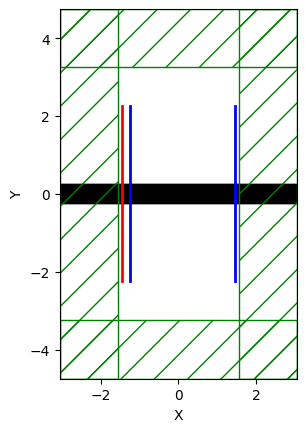

In [33]:
gm.write_sparameters_meep(c, ymargin=3, run=False)

In [34]:
c1_dict = {"component": c, "ymargin": 3}
jobs = [
    c1_dict,
]

filepaths = gm.write_sparameters_meep_batch_1x1(
    jobs=jobs,
    cores_per_run=4,
    total_cores=8,
    lazy_parallelism=True,
)

2023-01-22 16:16:53.190 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:138 - Simulation PosixPath('/home/runner/.gdsfactory/sp/straight_length3p1_c96b95b7.npz') not found. Adding it to the queue


2023-01-22 16:16:53.191 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:146 - Running 1 simulations


2023-01-22 16:16:53.192 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:147 - total_cores = 8 with cores_per_run = 4


2023-01-22 16:16:53.193 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:148 - Running 1 batches with up to 2 jobs each.


  0%|          | 0/1 [00:00<?, ?it/s]

2023-01-22 16:16:53.208 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:159 - Task 0 of batch 0 is job 0


2023-01-22 16:16:53.211 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/runner/.gdsfactory/sp/straight_length3p1_77964806.npz') already exists


{'component': straight_length3p1: uid 1bb457ee, ports ['o1', 'o2'], references [], 1 polygons,
 'ymargin': 3}


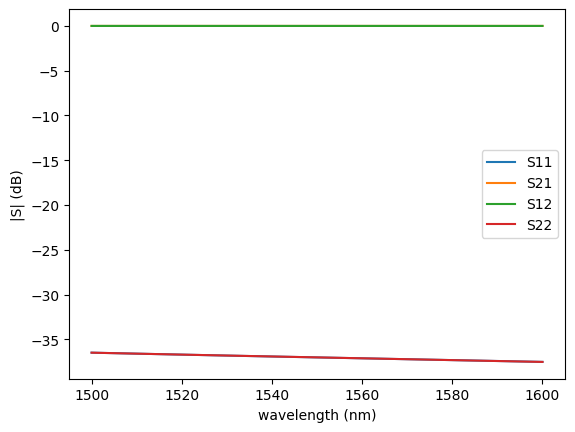

In [35]:
sp = np.load(filepaths[0])
gf.simulation.plot.plot_sparameters(sp)

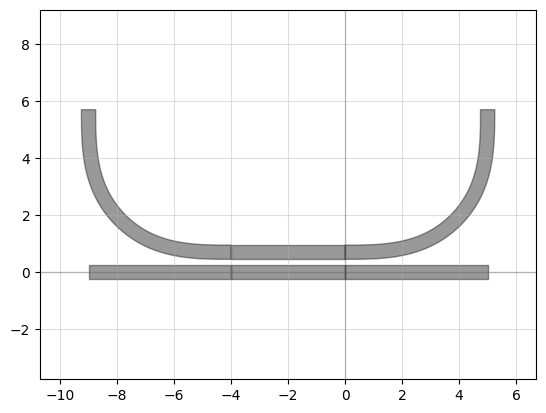

coupler_ring: uid 9259b306, ports ['o2', 'o1', 'o3', 'o4'], references ['coupler90_1', 'coupler90_2', 'coupler_straight_1'], 0 polygons

In [36]:
c = gf.components.coupler_ring()
c

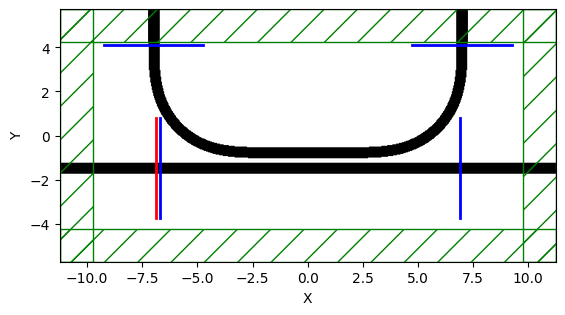

In [37]:
p = 2.5
gm.write_sparameters_meep(c, ymargin=0, ymargin_bot=p, xmargin=p, run=False)

In [38]:
c1_dict = dict(
    component=c,
    ymargin=0,
    ymargin_bot=p,
    xmargin=p,
)
jobs = [c1_dict]

filepaths = gm.write_sparameters_meep_batch(
    jobs=jobs,
    cores_per_run=4,
    total_cores=8,
    delete_temp_files=False,
    lazy_parallelism=True,
)

2023-01-22 16:17:00.935 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:138 - Simulation PosixPath('/home/runner/.gdsfactory/sp/coupler_ring_3c1ecefe.npz') not found. Adding it to the queue


2023-01-22 16:17:00.936 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:146 - Running 1 simulations


2023-01-22 16:17:00.939 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:147 - total_cores = 8 with cores_per_run = 4


2023-01-22 16:17:00.939 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:148 - Running 1 batches with up to 2 jobs each.


  0%|          | 0/1 [00:00<?, ?it/s]

2023-01-22 16:17:00.955 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:159 - Task 0 of batch 0 is job 0


2023-01-22 16:17:00.961 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/runner/.gdsfactory/sp/coupler_ring_9d887f79.npz') already exists


{'component': coupler_ring: uid 9259b306, ports ['o2', 'o1', 'o3', 'o4'], references ['coupler90_1', 'coupler90_2', 'coupler_straight_1'], 0 polygons,
 'xmargin': 2.5,
 'ymargin': 0,
 'ymargin_bot': 2.5}


In [39]:
sp = np.load(filepaths[0])

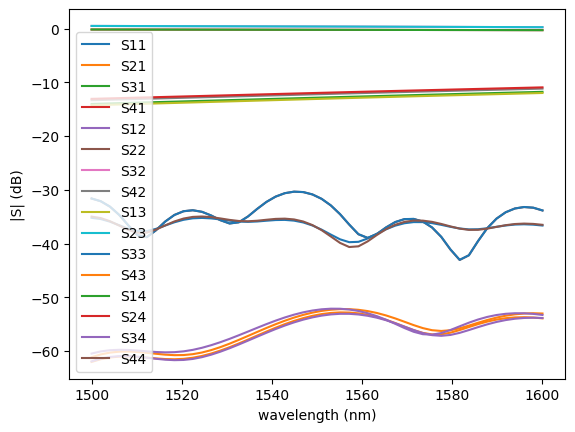

In [40]:
gm.plot.plot_sparameters(sp)

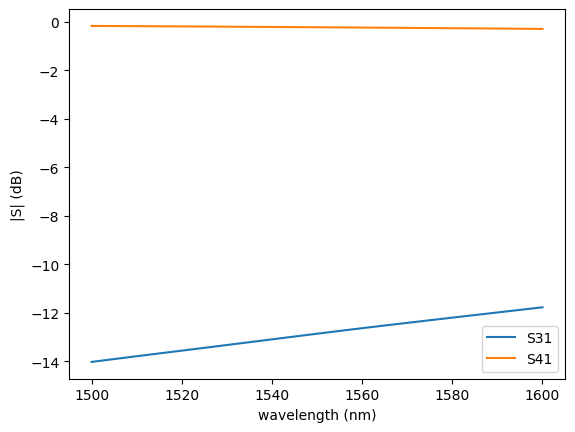

In [41]:
gm.plot.plot_sparameters(sp, keys=["o3@0,o1@0", "o4@0,o1@0"])

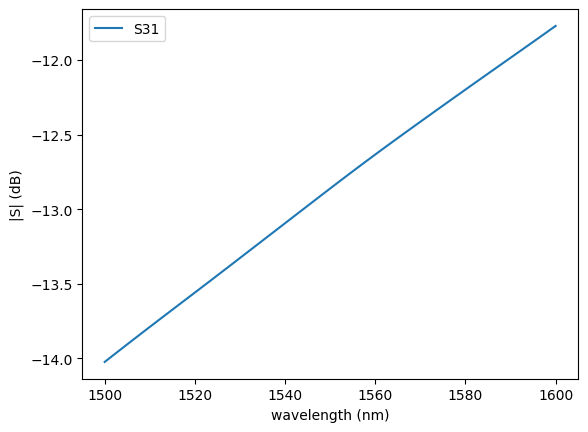

In [42]:
gm.plot.plot_sparameters(sp, keys=["s31"], with_simpler_input_keys=True)

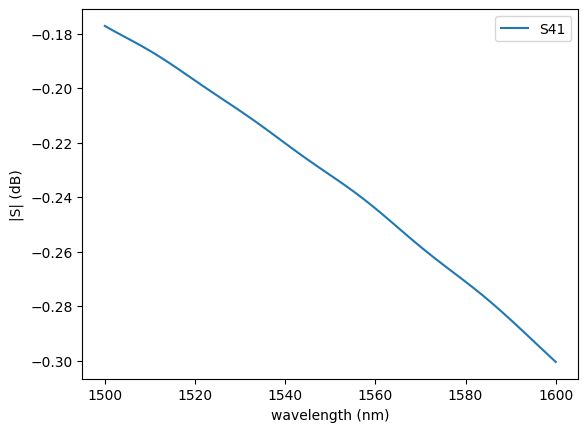

In [43]:
gm.plot.plot_sparameters(sp, keys=["s41"], with_simpler_input_keys=True)

## Visualizing the 3D Geometry

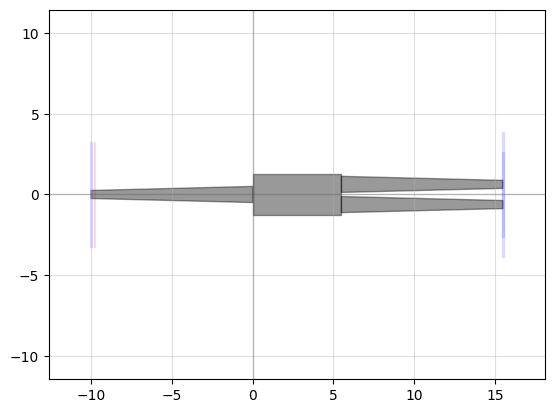

mmi1x2_add_simulation_m_ac12a352: uid 0fd1c4dd, ports ['o1', 'o2', 'o3'], references ['mmi1x2_1'], 4 polygons

In [44]:
c = gf.components.mmi1x2()
c = add_simulation_markers(c)
c

In [45]:
scene = c.to_3d()
scene.show()

## Adjoint Optimization

gdsfactory extends Meep's Adjoint Optimization features to optimize and generate primitive photonic components.

This example is based on this [Meep Adjoint Optimization tutorial](https://nbviewer.org/github/NanoComp/meep/blob/master/python/examples/adjoint_optimization/04-Splitter.ipynb)

We define some useful variables that we will need later. We can leave out many of the small design parameters by defining a minimum length and applying that to a filter and using that as a constraint in our optimization.

In [46]:
design_region_width = 2.5
design_region_height = 3.5

eta_e = 0.55
minimum_length = 0.1
filter_radius = get_conic_radius_from_eta_e(minimum_length, eta_e)
eta_i = 0.5
eta_d = 1 - eta_e

resolution = 20
design_region_resolution = int(5 * resolution)

Nx = int(design_region_resolution * design_region_width)
Ny = int(design_region_resolution * design_region_height)

pml_size = 1.0
waveguide_length = 1.5
waveguide_width = 0.5
Sx = 2 * pml_size + 2 * waveguide_length + design_region_width
Sy = 2 * pml_size + design_region_height + 0.5
cell_size = (Sx, Sy)

SiO2 = Medium(index=1.44)
Si = Medium(index=3.4)

We define the design region, design variables, and the component to optimize.

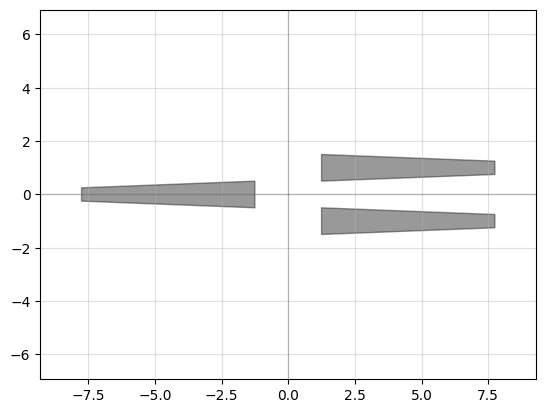

mmi1x2: uid 3524266f, ports ['o1', 'o2', 'o3'], references ['taper_1', 'taper_2', 'taper_3'], 0 polygons

In [47]:
design_variables = MaterialGrid(Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = DesignRegion(
    design_variables,
    volume=Volume(
        center=Vector3(),
        size=Vector3(design_region_width, design_region_height, 0),
    ),
)

c = gf.Component("mmi1x2")

arm_separation = 1.0
straight1 = c << gf.components.taper(6.5, width2=1)
straight1.move(straight1.ports["o2"], (-design_region_width / 2.0, 0))
straight2 = c << gf.components.taper(6.5, width1=1, width2=0.5)
straight2.move(straight2.ports["o1"], (design_region_width / 2.0, 1))
straight3 = c << gf.components.taper(6.5, width1=1, width2=0.5)
straight3.move(straight3.ports["o1"], (design_region_width / 2.0, -1))

c.add_port("o1", port=straight1.ports["o1"])
c.add_port("o2", port=straight2.ports["o2"])
c.add_port("o3", port=straight3.ports["o2"])

c

We define the objective function, and obtain the optimization object.

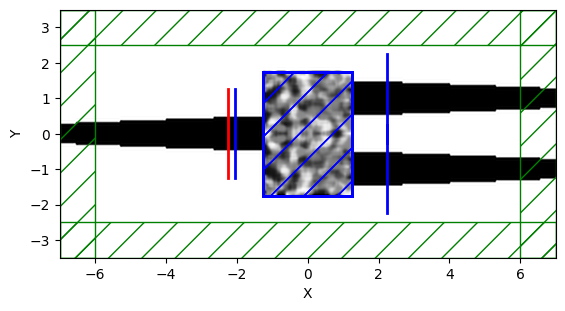

In [48]:
def mapping(x, eta, beta):

    # filter
    filtered_field = conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = tanh_projection(filtered_field, beta, eta)

    projected_field = (
        npa.fliplr(projected_field) + projected_field
    ) / 2  # up-down symmetry

    # interpolate to actual materials
    return projected_field.flatten()


seed = 240
np.random.seed(seed)
x0 = mapping(
    np.random.rand(
        Nx * Ny,
    ),
    eta_i,
    128,
)


def J(source, top, bottom):
    power = npa.abs(top / source) ** 2 + npa.abs(bottom / source) ** 2
    return npa.mean(power)


opt = gm.get_meep_adjoint_optimizer(
    c,
    J,
    [design_region],
    [design_variables],
    x0,
    resolution=resolution,
    cell_size=(
        Sx + 2 + design_region_width + 2 * pml_size,
        design_region_height + 2 * pml_size + 1.5,
    ),
    tpml=1.0,
    extend_ports_length=0,
    port_margin=1,
    port_source_offset=-5.5,
    port_monitor_offset=-5.5,
    symmetries=[mp.Mirror(direction=mp.Y)],
    wavelength_points=10,
)

We'll define a simple objective function that returns the gradient, and records the figure of merit. We'll plot the new geometry after each iteration.

In [49]:
evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print(f"Current iteration: {cur_iter[0] + 1}")

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    plt.show()

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )

    evaluation_history.append(np.max(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

We can define bitmasks to describe the boundary conditions.

In [50]:
# Define spatial arrays used to generate bit masks
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

# Define the core mask
left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width)
top_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g + arm_separation) <= waveguide_width
)
bottom_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g - arm_separation) <= waveguide_width
)
Si_mask = left_wg_mask | top_right_wg_mask | bottom_right_wg_mask

# Define the cladding mask
border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

We can then finally run the optimizer, and visualize the optimized component.

In [51]:
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1  # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0  # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx * Ny,))
ub[SiO2_mask.flatten()] = 0

cur_beta = 4
beta_scale = 2
num_betas = 7
update_factor = 12
run_optimization = False

if run_optimization:
    for iters in range(num_betas):
        print("current beta: ", cur_beta)

        if iters != num_betas - 1:
            x[:] = gm.run_meep_adjoint_optimizer(
                n,
                lambda a, g: f(a, g, cur_beta),
                x,
                lower_bound=lb,
                upper_bound=ub,
                maxeval=update_factor,
            )
        else:
            optimized_component = gm.run_meep_adjoint_optimizer(
                n,
                lambda a, g: f(a, g, cur_beta),
                x,
                lower_bound=lb,
                upper_bound=ub,
                maxeval=update_factor,
                get_optimized_component=True,
                opt=opt,
                threshold_offset_from_max=0.09,
            )
        cur_beta = cur_beta * beta_scale

    optimized_component.plot()
    final_figure_of_merit = 10 * np.log10(
        0.5 * np.array(evaluation_history[-1])
    )  # around -3.7 dB

The final optimized structure should look like this:

![optimized structure](https://user-images.githubusercontent.com/100642027/194617052-5cf0de3e-0294-441e-acad-9cd5e98ccd0b.png)

![optimization](https://user-images.githubusercontent.com/100642027/194617366-97b3e797-1fa4-40ed-8487-a5ac2b679493.png)